In [17]:
import cv2
import matplotlib.pyplot as plt

import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve

from scipy.interpolate import RBFInterpolator, bisplev
from scipy.stats.qmc import Halton


For each pixelX in the destination
    DSUM = (0,0)
    weightsunr=()
    
    For each line P_i Q_i 
        calculate U,V basedon P_i Q_i
        calculate X’_i based on U,V and P_i’ Q_i’
        calculate displacement D_i=X_i’-X_i for this line 
        dist =shortest distance from X to P_i Q_i
        weight = (length/(a+dist))^b
        DSUM += D_i * weight
        weightsum += weight
    X’ = X + DSUM/weightsum
    
destinationlmage(X)=sourceImage(X’)

[[0.1  0.1 ]
 [0.05 0.1 ]
 [0.1  0.15]
 [0.15 0.1 ]
 [0.1  0.05]]
(5, 2) (5,)


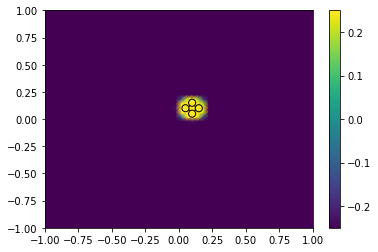

In [22]:
rng = np.random.default_rng()
xobs = 2 * Halton(2, seed=rng).random(10000) - 1
yobs = np.sum(xobs, axis=1) * np.exp(-6*np.sum(xobs**2, axis=1))

xobs = np.array([[0.1, 0.1],
                [0.05, 0.1],
                [0.1, 0.15],
                [0.15, 0.1],
                [0.1, 0.05]])

yobs = np.array([2, 1, 1, 1, 1])



print(xobs)
print(xobs.shape, yobs.shape)

xgrid = np.mgrid[-1:1:50j, -1:1:50j]

xflat = xgrid.reshape(2, -1).T
interpolator = RBFInterpolator(xobs, yobs, kernel='thin_plate_spline', neighbors = 4)
yflat = interpolator(xflat)
ygrid = yflat.reshape(50, 50)

#print(interpolator._coeffs)
#print(interpolator.tck)
#Z_x = bisplev(xt, yt, interpolator.tck, dx=1, dy=0)

#print(interpolator.derivative())
#print(interpolator)


fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, vmin=-0.25, vmax=0.25, shading='gouraud')
p = ax.scatter(*xobs.T, c=yobs, s=50, ec='k', vmin=-0.25, vmax=0.25)
fig.colorbar(p)
plt.show()
  

10000
[[224 255 255 ... 255 255 241]
 [225 255 255 ... 255 255 241]
 [225 255 255 ... 255 255 241]
 ...
 [224 255 255 ... 255 255 241]
 [224 255 255 ... 255 255 241]
 [217 224 220 ... 220 224 224]]


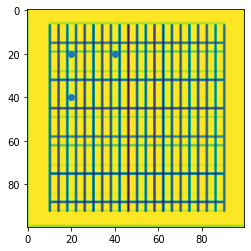

In [19]:
image = cv2.imread('grid.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (100, 100))

MN = image.shape[0] * image.shape[1]
print(MN)
p_points = np.array([[20, 20],
                    [20, 40],
                    [40, 20]])
q_points = np.array([[40, 40],
                    [20, 40],
                    [40, 20]])
print(image)
plt.imshow(image)
plt.scatter(x=p_points[:,0], y=p_points[:,1])
#plt.scatter(x=q_points[:,0], y=q_points[:,1])


y, x = np.meshgrid(range(0, image.shape[0]), range(0, image.shape[1]))



In [4]:
image.shape

w = np.zeros((MN, 2))
w[:, 0] = x.reshape(-1) #add the x coordinates
w[:, 1] = y.reshape(-1) #add the y coordinates

q = np.zeros((MN, 2))
I_diag = np.zeros(MN)

for i, (original_node, destination_node) in enumerate(zip(p_points, q_points)):

    p_index = np.where((w == original_node).all(axis=1))
    q_index = np.where((w == destination_node).all(axis=1))

    q[q_index] = destination_node
    I_diag[p_index] = 1


I = sparse.identity(MN)
I_prime = sparse.diags(I_diag, 0, dtype=np.int8)


In [5]:
alpha = 10.0
beta = 2500000.0
gamma = 0.0001

w

array([[  0.,   0.],
       [  0.,   1.],
       [  0.,   2.],
       ...,
       [643., 595.],
       [643., 596.],
       [643., 597.]])

In [6]:
#try with A = Identity
#try with B() =1

print((I_prime @ w)[(I_prime @ w).nonzero()[0], (I_prime @ w).nonzero()[1]])
print(q[q.nonzero()[0], q.nonzero()[1]])



print((I_prime @ w - q)[(I_prime @ w - q).nonzero()[0], (I_prime @ w - q).nonzero()[1]])

beta * (I_prime @ w - q)

[100. 100. 100. 200. 200. 100.]
[100. 200. 200. 100. 200. 200.]
[ 100.  100. -200. -200.]


array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [ ]:
Ax = A + alpha * B_y + gamma * I + beta I_prime
Ay = A + alpha * B_x + gamma * I + beta I_prime

bx = gamma * I @ x_t1 + beta * x_q
by = gamma * I @ y_t1 + beta * y_q

x_t = spsolve(Ax, bx)
y_t = spsolve(Ay, by) 